In [79]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
from joblib import Parallel, delayed


In [80]:
cpu_util_df = pd.read_csv("/Users/christinetsai/Desktop/ds4002/02-time-series-project/ds4002-project2/DATA/ec2_cpu_utilization_53ea38.csv")
cpu_util_df.head()

,timestamp,value
0,2014-02-14 14:30:00,1.732
1,2014-02-14 14:35:00,1.732
2,2014-02-14 14:40:00,1.960
3,2014-02-14 14:45:00,1.732
4,2014-02-14 14:50:00,1.706


In [81]:
# make sure timestamp col is datetime type
cpu_util_df["timestamp"]=pd.to_datetime(cpu_util_df["timestamp"])

In [82]:
''' build arima model
ARIMA's parameters: p, d, and q
p = for autoregression pt of model; how far back in time should we go to predict the current observation
d = order of differencing
q = for moving avg part of the model; represents num of lagged forecast errors included in the model 
'''
# train_size = int(len(cpu_util_df) * 0.8)
# train, test = cpu_util_df.iloc[:train_size], cpu_util_df.iloc[train_size:]
model_arima=ARIMA(cpu_util_df['value'],order=(5, 0, 5)) # using (5, 0, 5) as order based on running helper functions above that find this order for us
model_arima=model_arima.fit()



/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [83]:
# Returns the in-sample predictions for the training period
forecast_values = model_arima.fittedvalues.reset_index(drop=True)
forecast_values.head()

0    1.831289
1    1.841305
2    1.863596
3    1.826288
4    1.822511
dtype: float64

In [ ]:
# Get the in-sample predictions (fitted values) to calculate confidence bounds
fitted_values = model_arima.fittedvalues.reset_index(drop=True)

# Calculate residuals (actual - predicted) to compute std
residuals = cpu_util_df["value"] - fitted_values
std_resid = np.std(residuals)

# Define bounds using residual standard deviation
# z_score = 2.576  # 99% confidence
z_score = 3.5
upper_bound = fitted_values + (z_score * std_resid)
lower_bound = fitted_values - (z_score * std_resid)

In [99]:

cpu_util_df["lower_bound"] = lower_bound
cpu_util_df["upper_bound"] = upper_bound
cpu_util_df["is_anomaly"] = (
    (cpu_util_df["value"] > upper_bound)
).astype(int)
cpu_util_df.head(100)

,timestamp,value,lower_bound,upper_bound,is_anomaly
0,2014-02-14 14:30:00,1.732,1.575823,2.086755,0
1,2014-02-14 14:35:00,1.732,1.585838,2.096771,0
2,2014-02-14 14:40:00,1.960,1.608129,2.119062,0
3,2014-02-14 14:45:00,1.732,1.570822,2.081754,0
4,2014-02-14 14:50:00,1.706,1.567045,2.077977,0
...,...,...,...,...,...
95,2014-02-14 22:25:00,1.838,1.528621,2.039554,0
96,2014-02-14 22:30:00,1.966,1.556618,2.067551,0
97,2014-02-14 22:35:00,1.932,1.553993,2.064926,0
98,2014-02-14 22:40:00,2.162,1.650282,2.161214,1


In [ ]:
# sum up number of anomalies
cpu_util_df["is_anomaly"].sum()

29

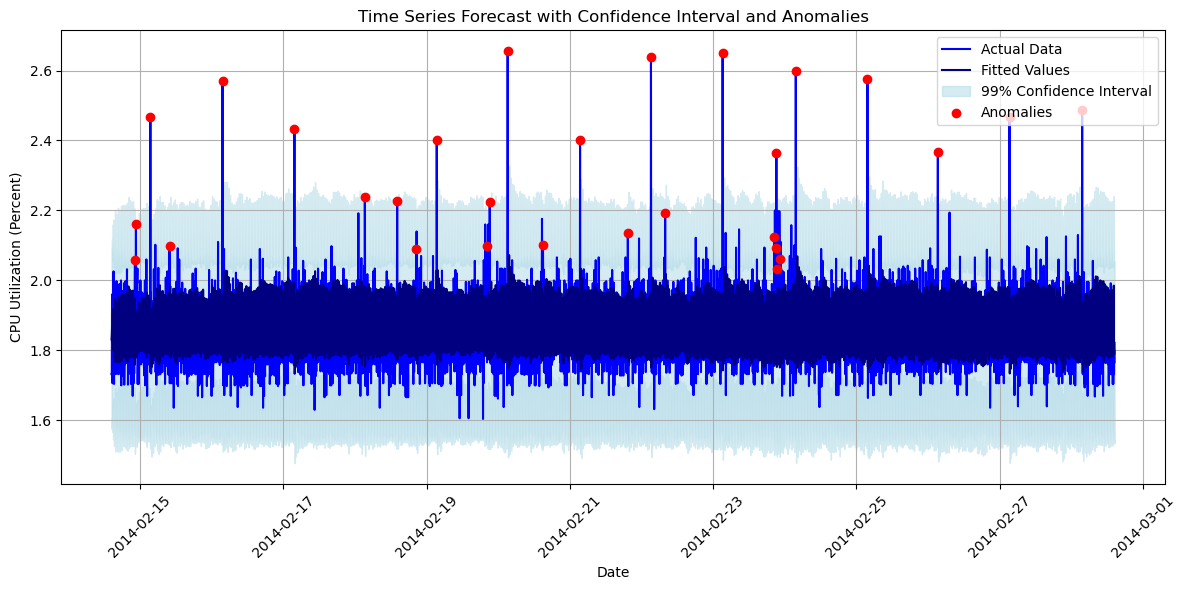

In [101]:
# Plot the forecasted values with the confidence intervals
from matplotlib.dates import DateFormatter, DayLocator
import matplotlib.dates as mdates


plt.figure(figsize=(12, 6))
plt.plot(cpu_util_df['timestamp'], cpu_util_df['value'], label="Actual Data", color='blue')
plt.plot(cpu_util_df['timestamp'], fitted_values, label="Fitted Values", color='navy')
plt.fill_between(cpu_util_df['timestamp'], lower_bound, upper_bound, color='lightblue', alpha=0.5, label="99% Confidence Interval")
anomalies = cpu_util_df[cpu_util_df["is_anomaly"] == 1]
plt.scatter(
    anomalies['timestamp'],
    anomalies['value'],
    color='red',
    label="Anomalies",
    zorder=5,
)
plt.xlabel("Date")
plt.ylabel("CPU Utilization (Percent)")
plt.title("Time Series Forecast with Confidence Interval and Anomalies")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()